# Imports

In [ ]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install transformers
# !pip install ipywidgets
# !pip install xgboost
# !pip install seaborn
# !pip install statsmodels
# !pip install wordcloud

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV

# Explore Data

Ratio of Spam vs Not Spam messages:
Not Spam: 86.59%
Spam: 13.41%


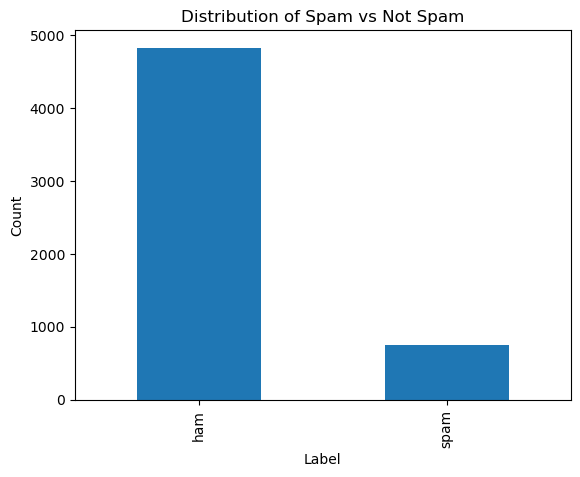

Total Messages: 5572
Average Length of Messages: 80.11880832735105
Unique Words: 8707


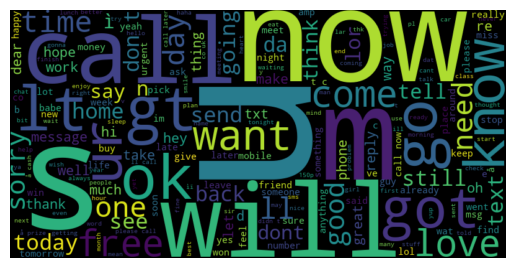

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1') # Use latin-1 to deal wuth unknown characters in ACSII
df = df[['v1','v2']]

# To ensure we are considering "ExAmpLe" is the same word as "example"
def clean_text(text):
    text = text.lower()
    return "".join([ch if ch.isalnum() else " " for ch in text])

df['v2'] = df['v2'].apply(clean_text)

# Calculate the ratio of Not Spam messages
not_spam_ratio = (df[df['v1'] == 'ham'].count() / len(df)) * 100
spam_ratio = (df[df['v1'] == 'spam'].count() / len(df)) * 100

# Print statement with formatted output
print(f"Ratio of Spam vs Not Spam messages:\nNot Spam: {not_spam_ratio['v1']:.2f}%\nSpam: {spam_ratio['v1']:.2f}%")
df['v1'].value_counts().plot(kind='bar')
plt.title('Distribution of Spam vs Not Spam')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Test Stats
print("Total Messages:", len(df))
print("Average Length of Messages:", df['v2'].str.len().mean())
print("Unique Words:", df['v2'].str.split(expand=True).stack().nunique())

# Word frequency 
all_words = ' '.join(df['v2'])
wordcloud = WordCloud(width=800, height=400).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can notice that the dataset we are using is very imbalanced, which is something that we need to take into account when building our models

# Set Up Data

In [ ]:
df.rename(columns={'v1':'label','v2':'text'}, inplace=True)

# ham = not spam = 0, spam = 1
mapping = {'ham': 0, 'spam': 1}
# Apply mapping
df['encoded_label'] = df['label'].map(mapping)

# Create variables
texts = df['text']
labels = df['encoded_label']

# Train test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels #stratify labels because of imbalanced dataset
)

# Classic machine learning - TF-IDF 

In [49]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=3000)
X_train_TFIDF = tfidf.fit_transform(X_train).toarray()
X_test_TFIDF = tfidf.fit_transform(X_test).toarray()

# Models
clfs = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5,class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")
    # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Define parameter grids for other classifiers
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3]
    }
}

results = {}

for name, model in clfs.items():
    # Initialize GridSearchCV
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='precision')
    grid_search.fit(X_train_TFIDF, y_train)
    
    # Predict using the best estimator
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_TFIDF)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)

    # Store results
    results[name] = {"accuracy": acc, "precision": prec, "best_params": grid_search.best_params_}

results



===== Logistic Regression =====
Accuracy: 0.8161434977578476
Precision: 0.24545454545454545


KeyboardInterrupt: 


===== Logistic Regression =====
Accuracy: 0.8502242152466367
Precision: 0.2


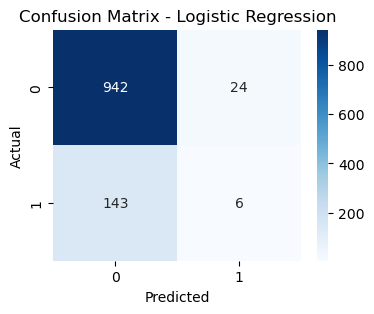


===== Decision Tree =====
Accuracy: 0.862780269058296
Precision: 0.0


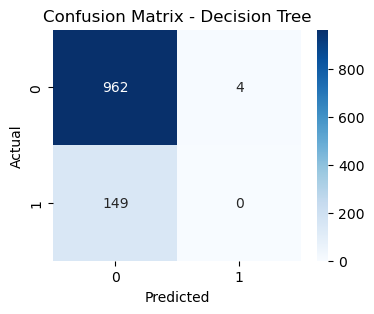


===== XGBoost =====
Accuracy: 0.863677130044843
Precision: 0.0


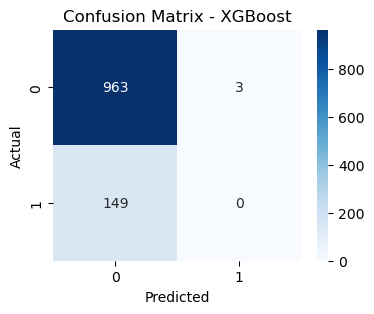

{'Logistic Regression': {'accuracy': 0.8502242152466367, 'precision': 0.2},
 'Decision Tree': {'accuracy': 0.862780269058296, 'precision': 0.0},
 'XGBoost': {'accuracy': 0.863677130044843, 'precision': 0.0}}

In [47]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=3000)
X_train_TFIDF = tfidf.fit_transform(X_train).toarray()
X_test_TFIDF = tfidf.fit_transform(X_test).toarray()

# Models
clfs = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5,class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")
    # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in clfs.items():
    model.fit(X_train_TFIDF, y_train)
    y_pred = model.predict(X_test_TFIDF)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)

    # Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    results[name] = {"accuracy": acc, "precision": prec}

results

# Bert Model

In [9]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
df = pd.read_csv('spam.csv', encoding="latin-1")

# changing spam classification to numeric: 0 for not spam, 1 for spam
df['label'] = df['v1'].map({'ham': 0, 'spam': 1})

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Prepare Dataset
- tokenizing the dataset
- padding the tokens
- tell model to ignore the padded values (aka masking)

In [12]:
tokenized = df['v2'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print("Padded array shape:")
print(np.array(padded).shape)

attention_mask = np.where(padded != 0, 1, 0)
print("Masked data shape:")
print(attention_mask.shape)

Padded array shape:
(5572, 238)
Masked data shape:
(5572, 238)


## Using Bert
- logistic regression

In [13]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [32]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df["label"]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)


===== Logistic Regression =====
Accuracy: 0.9899497487437185
Precision: 0.9836065573770492


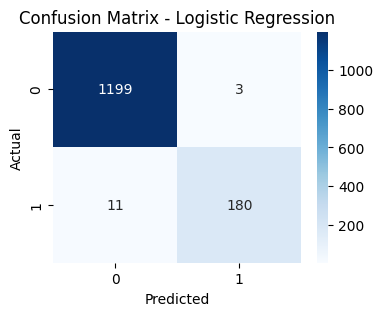


===== Decision Tree =====
Accuracy: 0.9691313711414213
Precision: 0.9302325581395349


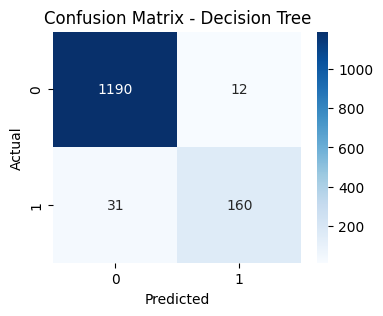


===== XGBoost =====
Accuracy: 0.9842067480258435
Precision: 0.9774011299435028


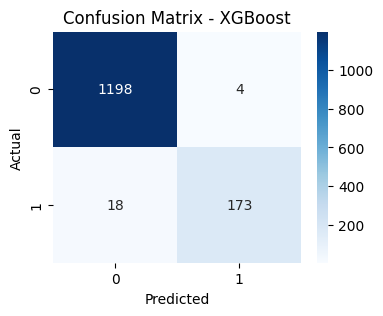


===== Gradient Boosting =====
Accuracy: 0.9849246231155779
Precision: 0.9829545454545454


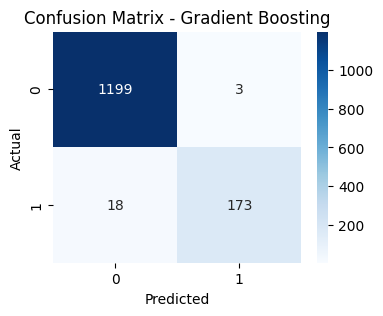

{'Logistic Regression': {'accuracy': 0.9899497487437185,
  'precision': 0.9836065573770492},
 'Decision Tree': {'accuracy': 0.9691313711414213,
  'precision': 0.9302325581395349},
 'XGBoost': {'accuracy': 0.9842067480258435, 'precision': 0.9774011299435028},
 'Gradient Boosting': {'accuracy': 0.9849246231155779,
  'precision': 0.9829545454545454}}

In [33]:
bert_models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss"),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results_bert = {}

for name, model in bert_models.items():

    # Train on full train set
    model.fit(train_features, train_labels)

    # Predict on test set
    y_pred = model.predict(test_features)

    # Metrics
    
    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred, zero_division=0)

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)

    # Heatmap
    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save results
    results_bert[name] = {
        "accuracy": acc,
        "precision": prec
    }

results_bert
